In [6]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d arjunvankani/recommendation-system-challenge-music-suggestion

 98% 694M/709M [00:06<00:00, 116MB/s]
100% 709M/709M [00:06<00:00, 112MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/recommendation-system-challenge-music-suggestion.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Importing datasets


In [10]:
train_data = pd.read_csv("/content/recommendation challenge (Music)/train.csv/train.csv")
train_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [11]:
test_data = pd.read_csv('/content/recommendation challenge (Music)/test.csv/test.csv')
test_data.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [12]:
songs = pd.read_csv('/content/recommendation challenge (Music)/songs.csv/songs.csv')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [13]:
members =pd.read_csv('/content/recommendation challenge (Music)/members.csv/members.csv')
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


# EDA

In [20]:
merged = train_data.merge(songs, on='song_id', how='left')
merged = merged.merge(members, on='msno', how='left')
merged.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,1,0,NaN,7,20120102,20171005


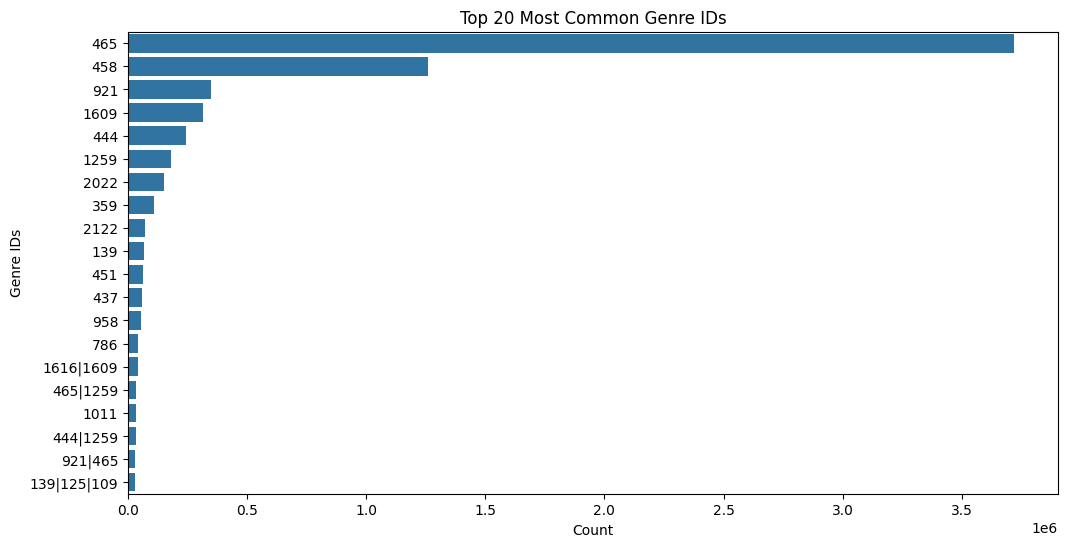

In [16]:
# Distribution of genre_ids
plt.figure(figsize=(12, 6))
sns.countplot(y='genre_ids', data=merged, order=merged['genre_ids'].value_counts().index[:20])
plt.title('Top 20 Most Common Genre IDs')
plt.xlabel('Count')
plt.ylabel('Genre IDs')
plt.show()

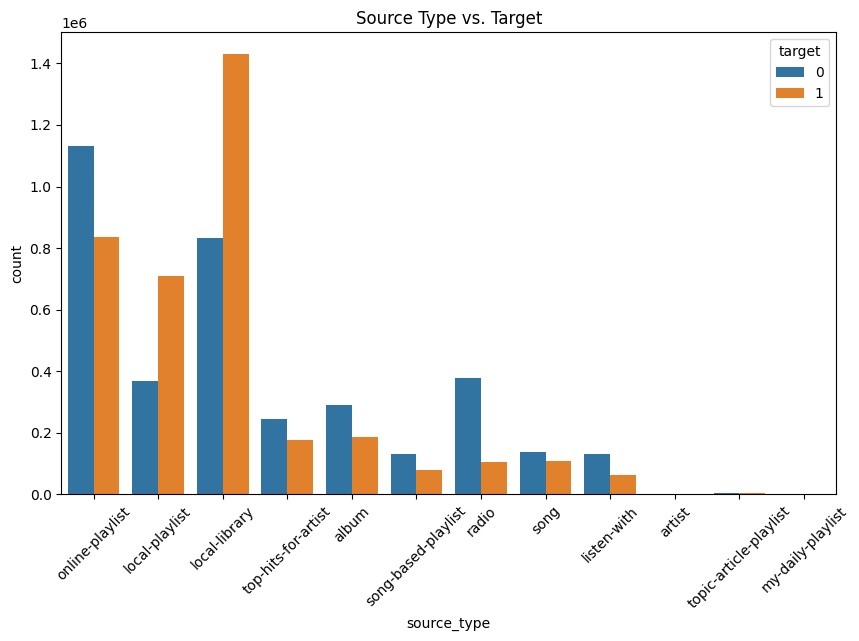

In [70]:
# Relationship between source type and target
plt.figure(figsize=(10, 6))
sns.countplot(x='source_type', hue='target', data=merged)
plt.title('Source Type vs. Target')
plt.xticks(rotation=45)
plt.show()

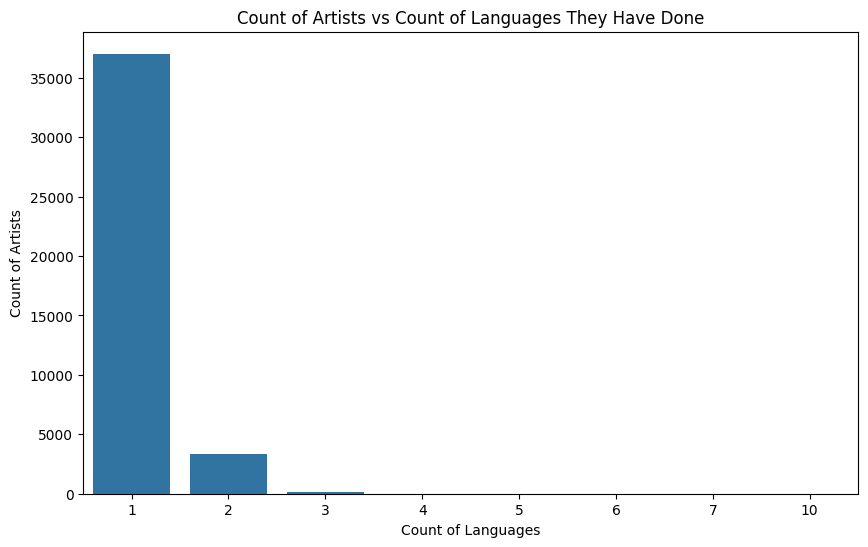

In [22]:
# Distribution of artists and languages have done

# Group by artist_name and count unique languages
artist_language_count = merged.groupby('artist_name')['language'].nunique().reset_index()
artist_language_count.columns = ['artist_name', 'language_count']

# Group by language and count unique artists
language_artist_count = artist_language_count.groupby('language_count').size().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='language_count', y='count', data=language_artist_count)
plt.title('Distribution of artists and languages have done')
plt.xlabel('Count of languages')
plt.ylabel('Count of artists')
plt.show()

# Pre-processing


In [23]:
train_data.dropna(inplace=True)

In [24]:
test_data.dropna(inplace=True)

# KNN using collaborative method


In [26]:
label_encoder = LabelEncoder()
for col in ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type']:
    train_data[col] = label_encoder.fit_transform(train_data[col])

# Split data into features and target variable and train and validation set
X = train_data.drop('target', axis=1)
y = train_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# kNN model
k = 5  # Number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=k)

# Fiting model on training data
knn_model.fit(train_data.drop('target', axis=1), train_data['target'])

# Predict target variable based on neighbors' behavior
query_point = train_data.drop('target', axis=1).iloc[0].values.reshape(1, -1)
distances, indices = knn_model.kneighbors(query_point)
nearest_neighbors_targets = train_data['target'].iloc[indices[0]]
predicted_target = nearest_neighbors_targets.mean()

In [28]:
# Predictions
y_pred = knn_model.predict(X_test)

In [31]:
# Evaluation
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy * 100, 2))

Accuracy: 69.97


In [3]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [6]:
user_id_mapping = {msno: i+1 for i, msno in enumerate(df['msno'].unique())}
df['user_id_numerical'] = df['msno'].map(user_id_mapping)

In [7]:
song_id_mapping = {songid: i+1 for i, songid in enumerate(df['song_id'].unique())}
df['song_id_numerical'] = df['song_id'].map(song_id_mapping)

In [8]:
df.shape

(7377418, 8)

In [9]:
df['user_id_numerical'].unique().shape

(30755,)

In [10]:
df['song_id'].unique().shape

(359966,)

In [11]:
min_reviews_threshold = df.groupby('song_id').size().mean() + 15
user_review_counts = df.groupby('song_id').size()
valid_work = list(set(user_review_counts[user_review_counts >= min_reviews_threshold].index))

In [12]:
len(valid_work)

23323

In [13]:
filtered_df = df[df.song_id.isin(valid_work)]

In [14]:
filtered_df['user_id_numerical'].unique().shape

(30483,)

In [21]:
result_df = pd.pivot_table(filtered_df, values='target', index='user_id_numerical', columns='song_id_numerical', aggfunc='mean')

In [22]:
result_df.head()

song_id_numerical,1,5,6,7,8,10,12,13,14,15,...,349916,349926,349927,350073,350166,350681,350754,350819,351058,351922
user_id_numerical,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,NaN,1.0,0.0,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
result_df.shape

(30483, 23323)

In [24]:
result_df.fillna(0, inplace=True)

In [25]:
result_df.head()

song_id_numerical,1,5,6,7,8,10,12,13,14,15,...,349916,349926,349927,350073,350166,350681,350754,350819,351058,351922
user_id_numerical,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
result_df[1]

user_id_numerical
1        1.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
30751    0.0
30752    0.0
30753    0.0
30754    0.0
30755    0.0
Name: 1, Length: 30483, dtype: float64

In [65]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def recommend_songs_for_user(user, result_df, top_n=5):
    user_consumption = result_df.loc[user]
    
    consumed_indices = user_consumption[user_consumption != 0].index
    
    consumed_values = result_df[consumed_indices].values
    non_consumed_indices = user_consumption[user_consumption == 0].index
    
    non_consumed_values = result_df[non_consumed_indices].values

    similarity_scores = cosine_similarity(consumed_values.T, non_consumed_values.T)

    avg_similarity_scores = np.mean(similarity_scores, axis=0)

    sorted_indices = np.argsort(avg_similarity_scores)[::-1]
    
    recommended_song_indices = np.array(non_consumed_indices)[sorted_indices[:top_n]]
    
    return recommended_song_indices


user_id_here = 9
recommended_song_indices = recommend_songs_for_user(user_id_here, result_df)
print(recommended_song_indices)

[1130   45  629  973 1280]


In [ ]:
# song_deatils = pd.read_csv('')

In [301]:
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
from tensorflow import keras

warnings.filterwarnings('ignore')

In [5]:
train_df = pd.read_csv('/kaggle/input/recommendation-system-challenge-music-suggestion/recommendation challenge (Music)/train.csv/train.csv')

In [6]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [293]:
song_df = pd.read_csv('/kaggle/input/recommendation-system-challenge-music-suggestion/recommendation challenge (Music)/song_extra_info.csv/song_extra_info.csv')

In [294]:
song_df.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


- Collaborative filtering does not work well with new users and new items.
- So in order to tackle that limitations, we are training our model for the users with more than 20 songs and the items with more than 20 mentions in our dataset.

In [266]:
min_user_threshold = 20
min_songs_threshold = 20

In [268]:
cnt_users = pd.DataFrame(train_df.groupby('msno').size(), columns=['cnt'])
cnt_books = pd.DataFrame(train_df.groupby('song_id').size(), columns=['cnt'])

In [269]:
users = list(set(cnt_users.query('cnt >= @min_user_threshold').index))
songs = list(set(cnt_books.query('cnt >= @min_songs_threshold').index))

In [33]:
print(f'The number of users : {len(users)} and the number of books: {len(books)}')

The number of users : 24326 and the number of books: 36870


In [35]:
user_matrix = train_df[train_df.msno.isin(users)]
matrix = user_matrix[user_matrix.song_id.isin(books)]

In [36]:
print(train_df.shape, matrix.shape)

(7377418, 6) (6322834, 6)


In [270]:
user2idx = {o:i for i, o in enumerate(users)}
song2idx = {o:i for i, o in enumerate(songs)}

In [278]:
idx2user = {u:i for i, u in user2idx.items()}
idx2song = {s:i for i, s in song2idx.items()}

In [271]:
matrix['user'] = matrix['msno'].apply(lambda x: user2idx[x])
matrix['song'] = matrix['song_id'].apply(lambda x: song2idx[x])

In [219]:
n_latent_factors= 128
n_users = len(matrix['user'].unique())
n_songs = len(matrix['song'].unique())

In [237]:
batch_size=64
epochs=5

In [222]:
from keras import saving

# Neural Network Collaborative Filtering

- Traditional Matrix Factorization method tend to perform poorly, as it only takes account of the linear relationship between the user and the items.
- So, with the help of neural network, we can add find some complex relations between the user and the items, which can result in better performance of the model based collaborative filtering.
- In here, we have created a neural network model to find out the embeddings for the user and the songs. After the embedding, we have introduced few dense layers to find out the complex features of the each user and song.

In [300]:
@saving.register_keras_serializable('my_package')
class MF_Neural_Net_Model(keras.Model):
    def __init__(self, n_users, n_songs, n_latent_factors, reg = 0, dropout_rate=0.3, **kwargs):    
        super(MF_Neural_Net_Model, self).__init__(**kwargs)
        self.n_users = n_users
        self.n_songs = n_songs
        self.n_latent_factors = n_latent_factors
        self.reg = reg
        self.dropout_rate = dropout_rate

        self.user_embedding = keras.layers.Embedding(n_users, n_latent_factors, embeddings_regularizer=keras.regularizers.l2(reg), name='user_embedding')
        self.book_embedding = keras.layers.Embedding(n_songs, n_latent_factors, embeddings_regularizer=keras.regularizers.l2(reg), name='book_embedding')
        
    
        self.user_flatten = keras.layers.Flatten(name='FlattenUsers')
        self.book_flatten = keras.layers.Flatten(name='FlattenBooks')
        
        
        self.user_dense_1 = keras.layers.Dense(96, activation='relu')
        self.user_dense_2 = keras.layers.Dense(48, activation='relu')
        self.book_dense_1 = keras.layers.Dense(96, activation='relu')
        self.book_dense_2 = keras.layers.Dense(48, activation='relu')
                                            
        
        self.user_dropout = keras.layers.Dropout(dropout_rate)
        self.book_dropout = keras.layers.Dropout(dropout_rate)
        self.dot_sim = keras.layers.Dot(axes=1, name='Similarity-Dot-Product')
            
        self.dense_1 = keras.layers.Dense(96, activation='relu')
        self.dense_2 = keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        user_input, song_input = inputs
        user_embedding = self.user_embedding(user_input)
        song_embedding = self.book_embedding(song_input)
        

        user_vec = self.user_flatten(user_embedding)
        user_vec = self.user_dense_1(user_vec)
        user_vec = self.user_dense_2(user_vec)

        song_vec = self.book_flatten(song_embedding)
        song_vec = self.book_dense_1(song_vec)
        song_vec = self.book_dense_2(song_vec)

      
        user_vec = self.user_dropout(user_vec)
        song_vec = self.book_dropout(song_vec)
        sim = self.dot_sim([user_vec, song_vec])

        nn_inp = self.dense_1(sim)
      
        output = self.dense_2(nn_inp)
        
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'n_users': self.n_users,
            'n_songs': self.n_songs,
            'n_latent_factors': self.n_latent_factors,
            'reg': self.reg,
            'dropout_rate': self.dropout_rate
        })
        return config

In [254]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("NCF_model_nn.keras", monitor='val_loss', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
lr_decay_cb = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=1, factor=0.5, min_lr=1e-8)

In [258]:
model = MF_Neural_Net_Model(n_users, n_songs, n_latent_factors)

In [259]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])

In [260]:
History = model.fit([tf.convert_to_tensor(matrix.user),tf.convert_to_tensor(matrix.song)], tf.convert_to_tensor(matrix.target), batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[checkpoint_cb, lr_decay_cb, early_stopping_cb], verbose=1)

Epoch 1/5
88915/88915 ━━━━━━━━━━━━━━━━━━━━ 295s 3ms/step - auc_32: 0.7124 - loss: 0.6164 - precision_31: 0.6731 - recall_31: 0.6973 - val_auc_32: 0.6410 - val_loss: 0.7017 - val_precision_31: 0.5044 - val_recall_31: 0.6175 - learning_rate: 0.0010
Epoch 2/5
88915/88915 ━━━━━━━━━━━━━━━━━━━━ 292s 3ms/step - auc_32: 0.7662 - loss: 0.5739 - precision_31: 0.7131 - recall_31: 0.7258 - val_auc_32: 0.6452 - val_loss: 0.7152 - val_precision_31: 0.5096 - val_recall_31: 0.6097 - learning_rate: 0.0010
Epoch 3/5
88915/88915 ━━━━━━━━━━━━━━━━━━━━ 287s 3ms/step - auc_32: 0.7773 - loss: 0.5631 - precision_31: 0.7220 - recall_31: 0.7321 - val_auc_32: 0.6458 - val_loss: 0.7132 - val_precision_31: 0.5094 - val_recall_31: 0.6063 - learning_rate: 0.0010
Epoch 4/5
88915/88915 ━━━━━━━━━━━━━━━━━━━━ 287s 3ms/step - auc_32: 0.7836 - loss: 0.5570 - precision_31: 0.7299 - recall_31: 0.7292 - val_auc_32: 0.6461 - val_loss: 0.6739 - val_precision_31: 0.5238 - val_recall_31: 0.5499 - learning_rate: 0.0010
Epoch 5/5
88

In [261]:
import matplotlib.pyplot as plt

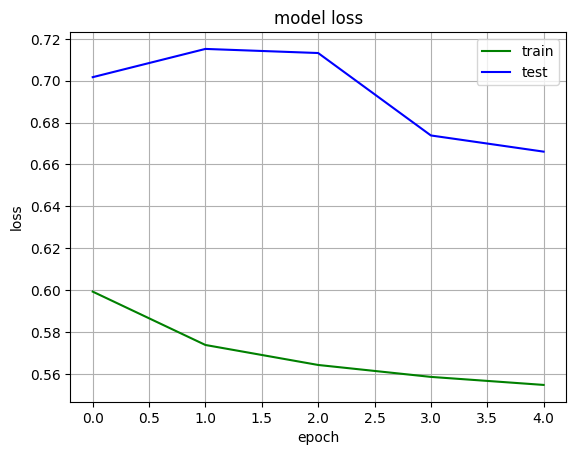

In [262]:
plt.plot(History.history['loss'], 'g')
plt.plot(History.history['val_loss'], 'b')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

- As we can see, our model is slowly learning and converging to the better and optimal solutions.
- Due to time constraints, we have trained the neural network model for only 5 epochs. But we can increase the number of epochs and the model may perform better.

In [263]:
test_df = pd.read_csv('/kaggle/input/recommendation-system-challenge-music-suggestion/recommendation challenge (Music)/test.csv/test.csv')

In [264]:
test_df.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [274]:
test_df['user'] = test_df['msno'].apply(lambda x: user2idx[x] if x in user2idx else -1)
test_df['song'] = test_df['song_id'].apply(lambda x: song2idx[x] if x in song2idx else -1)

In [275]:
test_df = test_df[(test_df['user'] != -1) & (test_df['song'] != -1)]b

In [276]:
model.predict([test_df.user, test_df.song])

52974/52974 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step


array([[0.3283291 ],
       [0.29152387],
       [0.21570525],
       ...,
       [0.16779816],
       [0.41749254],
       [0.39460856]], dtype=float32)

In [297]:
# Recommends songs to the user, using previously trained neural network model. 
# We are finding out the probability of each song and showing at most K songs to the user.
def make_recommendations(df, song_df, user, model, k = 10):
    if not user in idx2user:
        return 'Please listen to more songs to get the recommendations'
    
    prev_songs = df[df['user'] == user]['song_id']
    new_songs = [i for i in songs if i not in prev_songs]
    new_df = pd.DataFrame()
    
    new_df['song_id'] = new_songs
    new_df['user'] = user
    
    new_df['song'] = new_df['song_id'].apply(lambda x: song2idx[x])

    new_df['target'] = model.predict([new_df['user'], new_df['song']], verbose=0)
    
    
    top_k = new_df.sort_values('target', ascending=False).iloc[:k]
    
    top_k = top_k.merge(song_df, on='song_id')
    
    return top_k['name'].tolist()

In [299]:
make_recommendations(matrix, song_df, 0, model)

['I Miss You',
 'I will go to you like the first snow',
 'If Only',
 'Stuck in love',
 'Wish',
 'Who are you',
 'Beautiful',
 'HEAVEN',
 'LOVE',
 'You are so beautiful']